<hr style="border: none; border-top: 2px solid black;" />

---

# Notebook to read and plot SWIFT-BAT-GUANO data
---
<hr style="border: none; border-top: 2px solid black;" />


##### First we import the needed packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob, tables

from astropy.coordinates import EarthLocation, SkyCoord
from astropy.coordinates import AltAz
from astropy import units as u
from astropy.io import fits

import healpy as hp
import scipy.ndimage

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, append=True)
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")



import ligo.skymap.plot
from ligo.skymap.plot import blackmarble, reproject_interp_rgb, bluemarble
import ligo.skymap.io.fits
from astropy.io import fits

import plotting

# --- Hard-Coded parameters --- #
root = os.getcwd() # Root directory where the script is running
dir_plots = root + "/plots/" # Directory to store plots

In [2]:
from ligo.skymap.io.fits import read_sky_map

from matplotlib.colors import LogNorm
from scipy.ndimage import gaussian_filter
import mhealpy as mhp

def healpix2map(
    healpix_data,
    ra_bins, 
    dec_bins,
):
    
    ra_grid, dec_grid = np.meshgrid(ra_bins, dec_bins)

    # Convert the latitude and longitude to theta and phi
    theta, phi = np.radians(90 - dec_grid), np.radians(ra_grid)
    
    nside = hp.npix2nside(len(healpix_data)) # nside of the grid

    # Convert theta, phi to HEALPix indices and create a 2D map using the HEALPix data
    hp_indices = hp.ang2pix(nside, theta, phi)

    return (healpix_data[hp_indices])

def get_hp_map_thresholds(healpix_data, threshold_percent = [0.9, 0.68],):
    
    # We sort the tresholds itself in descending order
    threshold_percent = np.sort(threshold_percent)[::-1]
    
    # Sort in descending order and normalize
    sorted_data = np.sort(healpix_data)[::-1] / np.sum(healpix_data)
    cumulative_sum = np.cumsum(sorted_data)

    # Find the values corresponding to the thresholds
    indexes_map = [np.searchsorted(cumulative_sum, t) for t in threshold_percent]
    # Then we find the thresholds
    threshold_maps = [sorted_data[min(index, len(sorted_data) - 1)] for index in indexes_map]
    
    return threshold_maps

def get_2d_map_hotspot(map_data_2d, ra_bins, dec_bins):
    
    # Computing coordinate of maximum probability
    max_prob_index = np.unravel_index(np.argmax(map_data_2d), map_data_2d.shape)
    
    max_prob_ra, max_prob_dec = ra_bins[max_prob_index[1]], dec_bins[max_prob_index[0]]
    max_prob_coords = SkyCoord(ra=max_prob_ra, dec=max_prob_dec, unit=u.deg, frame="icrs")
    return max_prob_coords

In [3]:
filename = "./data/data_SWIFT-BAT-GUANO.fits"

source_name = "S241125n"

threshold_percent = [0.9, 0.68]

sigma_smoothing = 0.7
zoom_radius = 6 * u.deg

resolution_hp_to_grid = 2048
ra_bins  = np.linspace(-180, 180, resolution_hp_to_grid)
dec_bins = np.linspace(-90, 90, resolution_hp_to_grid)

ra_grid, dec_grid = np.meshgrid(ra_bins, dec_bins)


store_plots = True
dir_plots = "./plots/"

In [13]:
prob_dens_moc = mhp.HealpixMap.read_map(filename, field=1, density=True)

data_hp = prob_dens_moc.rasterize(nside=2**9).data

# Normalizing the data
data_hp = data_hp / np.sum(data_hp)

vmax = np.max(data_hp) #np.percentile(data_hp, 99.995)
vmin = np.percentile(data_hp[data_hp>0], 10.0)
vmin = max(np.percentile(data_hp, 99.99)/1e3, vmin)

In [14]:
# Converting the healpix data to a 2d map
data_2d = healpix2map(data_hp, ra_bins, dec_bins)
# Getting a smoothier version of the data
data_2d_smooth = gaussian_filter(data_2d, sigma=sigma_smoothing)

# Getting the thresholds for probability containment
threshold_maps = get_hp_map_thresholds(data_hp, threshold_percent)

# Getting the coordinate of hottest spot
hotspot_coords = get_2d_map_hotspot(data_2d, ra_bins, dec_bins)

### Reading also LIGO data

In [15]:
# Reading the healpix data array from the file
data_ligo_hp, meta_ligo_hp = read_sky_map("./data/data_LIGO.fits")

# Converting the healpix data to a 2d map
data_ligo_2d = healpix2map(data_ligo_hp, ra_bins, dec_bins)
# Getting a smoothier version of the data
data_ligo_2d_smooth = gaussian_filter(data_ligo_2d, sigma=sigma_smoothing)

# Getting the thresholds for probability containment
threshold_ligo_maps = get_hp_map_thresholds(data_ligo_hp, threshold_percent)

# Getting the coordinate of hottest spot
hotspot_ligo_coords = get_2d_map_hotspot(data_ligo_2d, ra_bins, dec_bins)

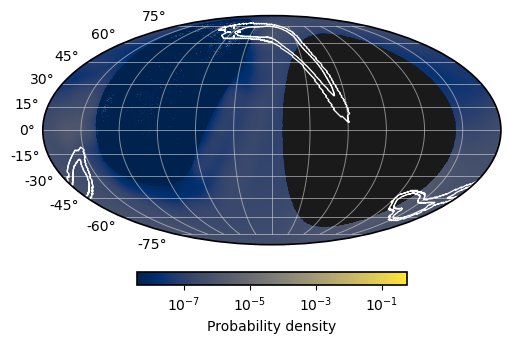

In [21]:
fig = plt.figure(figsize=(7, 3.5))
ax = fig.add_subplot(111, projection="mollweide")

# --- full skymap --- #
cmesh = ax.pcolormesh(
    np.deg2rad(ra_grid), 
    np.deg2rad(dec_grid), 
    np.flip(data_2d, axis=1), # Flipping for inverted astro RA view
    cmap="cividis", norm=LogNorm(vmin, vmax)
)
cbar = fig.colorbar(
    cmesh, ax=ax, orientation="horizontal", pad=0.1, fraction=0.05, aspect=20, label="Probability density")

# --- GW contour --- #
ax.contour(
    np.deg2rad(ra_grid), 
    np.deg2rad(dec_grid), 
    np.flip(data_ligo_2d, axis=1), # Flipping for inverted astro RA view
    levels=threshold_ligo_maps, colors="w", linewidths=0.9
)

# --- hotspot --- #
ax.plot(
    -np.deg2rad(hotspot_coords.ra.wrap_at(180 * u.deg).value), # Flipping and wrapping in -180, 180
    hotspot_coords.dec.rad,
    marker=ligo.skymap.plot.reticle(), markersize=10, color="w", markeredgewidth=1.4
)

ax.spines["geo"].set_linewidth(1.2); cbar.outline.set_linewidth(1.2)
ax.grid(color="lightgray", alpha=0.6, lw=0.7); ax.set_xticklabels([]); ax.set_facecolor("0.1")

if store_plots == True:
    plt.savefig(dir_plots + f"plot_SWIFT_mollweide_{source_name}.png", bbox_inches="tight", dpi=300)
plt.show()

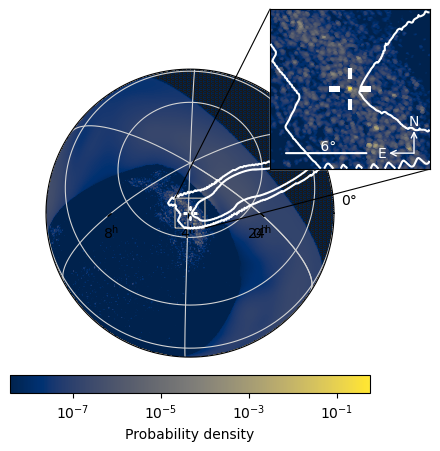

In [17]:
fig = plt.figure(figsize=(4, 4), dpi=100)
ax = fig.add_subplot([0.05, 0.05, 0.9, 0.9], projection="astro globe", center=hotspot_coords)

# --- inset axis --- #
ax_inset = fig.add_subplot([0.7, 0.7, 0.4, 0.4], projection="astro zoom", 
                           center=hotspot_coords, radius=zoom_radius)
for key in ["ra", "dec"]:
    ax_inset.coords[key].set_ticklabel_visible(False); ax_inset.coords[key].set_ticks_visible(False)
ax.mark_inset_axes(ax_inset)
ax_inset.scalebar((0.1, 0.1), zoom_radius, color="w").label(color="w")
ax_inset.compass(0.9, 0.1, 0.2, color="w"); ax.grid(color="lightgray")
lines_inset = [ax.connect_inset_axes(ax_inset, "upper left", zorder=10),
               ax.connect_inset_axes(ax_inset, "lower right", zorder=10)]
for line in lines_inset:
    line.set_color("k")  
rectangle = ax.mark_inset_axes(ax_inset)
rectangle.set_edgecolor("lightgray")

for axe, ms, mw in zip([ax, ax_inset], [10, 30], [2, 3]):
    # Skymap
    imshow = axe.imshow_hpx(data_hp, cmap="cividis", norm=LogNorm(vmin, vmax))
    # GW contour
    axe.contour_hpx(data_ligo_hp, colors="w", levels=threshold_ligo_maps, linewidths=1.5)
    # Hotspot
    axe.plot(hotspot_coords.ra.deg, hotspot_coords.dec.deg, transform=axe.get_transform("world"),
             marker=ligo.skymap.plot.reticle(), markersize=ms, color="w", markeredgewidth=mw)
    axe.set_facecolor("0.1")

cbar = fig.colorbar(
    imshow, ax=ax, orientation="horizontal", pad=0.05, label="Probability density",)

if store_plots == True:
    plt.savefig(dir_plots + f"plot_SWIFT_astroglobe_{source_name}.png", bbox_inches="tight", dpi=300)
plt.show()

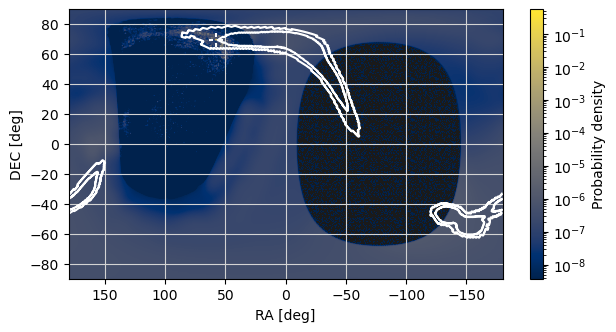

In [18]:
fig, ax = plt.subplots(figsize=(7, 3.5))

# --- skymap --- #
cmesh = ax.imshow(
    np.flip(data_2d, axis=1), # Flipping data to plot in inverted RA view
    extent=[180, -180, -90, 90], 
    aspect="auto", origin="lower", cmap="cividis", norm=LogNorm(vmin, vmax)
)

# --- GW contour --- #
ax.contour(
    np.flip(data_ligo_2d, axis=1),
    extent=[180, -180, -90, 90], 
    origin="lower", levels=threshold_ligo_maps, linewidths=1.5, colors="w")

# --- hotspot --- #
ax.plot(
    hotspot_coords.ra.wrap_at(180 * u.deg).value, # Wrapping in -180, 180
    hotspot_coords.dec.deg, 
    marker=ligo.skymap.plot.reticle(), markersize=10, color="w", markeredgewidth=1.4
)

ax.grid(color="lightgray"); ax.set_facecolor("0.1")
ax.set_xlabel("RA [deg]"); ax.set_ylabel("DEC [deg]")
cbar = plt.colorbar(cmesh, ax=ax, orientation="vertical", label="Probability density")

if store_plots == True:
    plt.savefig(dir_plots + f"plot_SWIFT_cartesian_{source_name}.png", bbox_inches="tight", dpi=300)
plt.show()

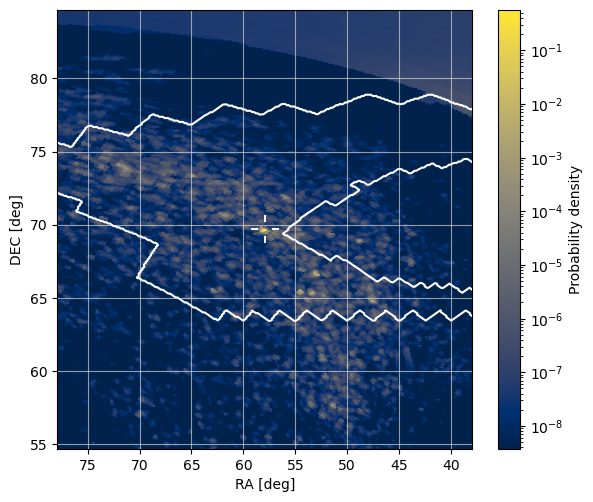

In [20]:
fig, ax = plt.subplots(figsize=(6.7, 5.7))

# --- skymap --- #
cmesh = ax.imshow(
    np.flip(data_2d, axis=1), # Flipping data to plot in inverted RA view
    extent=[180, -180, -90, 90], 
    aspect="auto", origin="lower", cmap="cividis", norm=LogNorm(vmin, vmax)
)

# --- GW contour --- #
ax.contour(
    np.flip(data_ligo_2d, axis=1),
    extent=[180, -180, -90, 90], 
    origin="lower", levels=threshold_ligo_maps, linewidths=1.5, colors="w")

# --- hotspot --- #
ax.plot(
    hotspot_coords.ra.wrap_at(180 * u.deg).value, # Wrapping in -180, 180
    hotspot_coords.dec.deg, 
    marker=ligo.skymap.plot.reticle(), markersize=20, color="w", markeredgewidth=1.4
)

ax.grid(color="lightgray", alpha=0.7); ax.set_facecolor("0.1")
ax.set_xlabel("RA [deg]"); ax.set_ylabel("DEC [deg]")
cbar = plt.colorbar(cmesh, ax=ax, orientation="vertical", label="Probability density")

ax.set_xlim(hotspot_coords.ra.deg+20, hotspot_coords.ra.deg-20)
ax.set_ylim(hotspot_coords.dec.deg-15, hotspot_coords.dec.deg+15)

if store_plots == True:
    plt.savefig(dir_plots + f"plot_SWIFT_cartesian_zoom_{source_name}.png", bbox_inches="tight", dpi=300)
plt.show()